# Init

In [1]:
import ast

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
pd.options.mode.chained_assignment = None

# Load pipeline

In [2]:
KEPT_CATEGORIES = ['Food', 'Restaurants', 'Cafes', 'Bakeries', 'Bars', 'Pubs', 'Food Trucks', 'Coffee & Tea']
def check_category_match(categories):
    if categories is None:
        return False
    else:
        return any([True for cat in categories if cat in KEPT_CATEGORIES])
    
def dict_to_cols(dict_str):
    try:
        d = ast.literal_eval(dict_str)
        return d
    except (ValueError, SyntaxError):
        return None
    
def get_parking(parking):
    try:
        parking = ast.literal_eval(parking)
        for key, value in parking.items():
            if value:
                return 1.0
        return 0.0
    except (ValueError, SyntaxError):
        return None

In [3]:
business_reader = pd.read_json('./Dataset/YELP/yelp_academic_dataset_business.json', encoding='utf-8',
                               orient='records', lines=True, chunksize=int(1e18))

for chunk in business_reader:
    chunk = chunk[['business_id', 'name', 'attributes', 'categories', 'city', 'latitude', 'longitude']]
    
    chunk.categories = chunk.categories.str.split(pat=', ')
    chunk = chunk[chunk.categories.apply(check_category_match)]
    
    chunk = pd.concat([chunk.drop('attributes', axis=1), 
                       chunk['attributes'].apply(pd.Series)], axis=1)
    
    chunk['BusinessParking'] = chunk['BusinessParking'].apply(get_parking)
    
    for col in ['GoodForMeal', 'Ambience', 'Music', 'DietaryRestrictions']:
        chunk[col] = chunk[col].apply(dict_to_cols)
        chunk = pd.concat([chunk.drop(col, axis=1), 
                           chunk[col].apply(pd.Series)], axis=1)
        
    chunk = chunk.drop(['BestNights', 'BusinessAcceptsBitcoin', 'HairSpecializesIn', 
                        'ByAppointmentOnly', 'AcceptsInsurance'], axis=1)
        
    chunk.replace({'True': 1.0, 'False': 0.0, True: 1.0, False: 0.0}, inplace=True)
    chunk.to_csv('./Dataset/YELP/business_attributes_raw.csv', index=False)
        
    print(chunk.columns)
    ids = pd.DataFrame(chunk.business_id.unique(), columns=['business_id'])

Index(['business_id', 'name', 'categories', 'city', 'latitude', 'longitude',
       'BikeParking', 'BusinessAcceptsCreditCards', 'BusinessParking',
       'GoodForKids', 'HasTV', 'NoiseLevel', 'OutdoorSeating',
       'RestaurantsAttire', 'RestaurantsDelivery', 'RestaurantsGoodForGroups',
       'RestaurantsPriceRange2', 'RestaurantsReservations',
       'RestaurantsTakeOut', 'Alcohol', 'Caters', 'DogsAllowed', 'DriveThru',
       'RestaurantsTableService', 'WheelchairAccessible', 'WiFi', 'BYOB',
       'BYOBCorkage', 'CoatCheck', 'Corkage', 'GoodForDancing', 'HappyHour',
       'Smoking', 'AgesAllowed', 'RestaurantsCounterService', 'Open24Hours',
       'dessert', 'latenight', 'lunch', 'dinner', 'breakfast', 'brunch',
       'romantic', 'intimate', 'classy', 'hipster', 'touristy', 'trendy',
       'upscale', 'casual', 'divey', 'dj', 'background_music', 'no_music',
       'karaoke', 'live', 'video', 'jukebox', 'dairy-free', 'gluten-free',
       'vegan', 'kosher', 'halal', 'soy-free', 

In [4]:
ratings = pd.read_json('./Dataset/YELP/yelp_academic_dataset_review.json',
                       lines=True, chunksize=100000, encoding='utf-8')
ratings_csv = './Dataset/YELP/ratings_raw.csv'

for idx, chunk in enumerate(ratings):
    chunk = chunk[['business_id', 'user_id', 'date', 'stars']]
    chunk = chunk.merge(ids, on='business_id', how='right')
    
    if idx > 0:
        chunk.to_csv(ratings_csv, index=False, mode='a', header=False)
    else:
        chunk.to_csv(ratings_csv, index=False, mode='w')

# EDA

In [3]:
business_df = pd.read_csv('./Dataset/YELP/business_attributes_raw.csv', encoding='utf-8', index_col=False)
ratings_df = pd.read_csv('./Dataset/YELP/ratings_raw.csv', encoding='utf-8', index_col=False)

In [4]:
business_df.head()

,business_id,name,categories,city,latitude,longitude,BikeParking,BusinessAcceptsCreditCards,BusinessParking,GoodForKids,...,live,video,jukebox,dairy-free,gluten-free,vegan,kosher,halal,soy-free,vegetarian
0,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,"['Tours', 'Breweries', 'Pizza', 'Restaurants',...",Calgary,51.091813,-114.031675,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AjEbIBw6ZFfln7ePHha9PA,CK'S BBQ & Catering,"['Chicken Wings', 'Burgers', 'Caterers', 'Stre...",Henderson,35.960734,-114.939821,0.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,O8S5hYJ1SMc8fA4QBtVujA,La Bastringue,"['Breakfast & Brunch', 'Restaurants', 'French'...",Montréal,45.540503,-73.599300,1.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,45bWSZtniwPRiqlivpS8Og,The Coffee Bean & Tea Leaf,"['Coffee & Tea', 'Food']",Phoenix,33.671375,-112.030017,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9A2quhZLyWk0akUetBd8hQ,Bnc Cake House,"['Food', 'Bakeries']",Toronto,43.664378,-79.414424,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
ratings_df.head()

,business_id,user_id,date,stars
0,iCQpiavjjPzJ5_3gPD5Ebg,msQe1u7Z_XuqjGoqhB0J5g,2011-02-25,2.0
1,iCQpiavjjPzJ5_3gPD5Ebg,D1_nrBr4dOrs7M82OaBRwQ,2011-10-25,3.0
2,iCQpiavjjPzJ5_3gPD5Ebg,jEjc8HxeCeI22M4di0Y1aw,2016-05-22,5.0
3,iCQpiavjjPzJ5_3gPD5Ebg,RTiaaHSN80VRTLSdNK5rfQ,2014-12-30,5.0
4,iCQpiavjjPzJ5_3gPD5Ebg,hBmJs49zYcXdV4wo8F5iiA,2013-03-24,5.0


In [6]:
b_num = business_df.shape[0]
b_num

75447

In [7]:
u_num = ratings_df['user_id'].unique().shape[0]
u_num

1090542

In [8]:
r_num = ratings_df.shape[0]
r_num

7061578

In [9]:
r_num / (b_num * u_num)

8.582570682014056e-05

In [10]:
city_ratings = ratings_df.merge(business_df[['business_id', 'city']], on='business_id')
city_ratings = city_ratings.groupby(['user_id', 'city']).count()['business_id'].reset_index(name='count')
city_ratings.sort_values('user_id').head(20)

,user_id,city,count
0,---1lKK3aKOuomHnwAkAow,Henderson,4
1,---1lKK3aKOuomHnwAkAow,Las Vegas,68
2,---1lKK3aKOuomHnwAkAow,North Las Vegas,1
3,---89pEy_h9PvHwcHNbpyg,Las Vegas,1
4,---94vtJ_5o_nikEs6hUjg,Phoenix,1
5,---PLwSf5gKdIoVnyRHgBA,Scottsdale,1
6,---cu1hq55BP9DWVXXKHZg,Phoenix,2
7,---udAKDsn0yQXmzbWQNSw,Las Vegas,2
8,--0LlX_UcypHnxW-4BUAdA,Mesa,1
9,--0RtXvcOIE4XbErYca6Rw,Charlotte,1


In [11]:
city_users = city_ratings.merge(city_ratings, on='user_id')
city_users = city_users.groupby(['city_x', 'city_y']).count()['user_id'].reset_index(name='count')
city_users.tail(10)

,city_x,city_y,count
73433,Île-des-Soeurs,Rougemont,1
73434,Île-des-Soeurs,Saint-Henri,1
73435,Île-des-Soeurs,Saint-Lambert,1
73436,Île-des-Soeurs,Saint-Sauveur,1
73437,Île-des-Soeurs,Sainte-Therese,1
73438,Île-des-Soeurs,Terrebonne,1
73439,Île-des-Soeurs,Toronto,3
73440,Île-des-Soeurs,Verdun,3
73441,Île-des-Soeurs,Westmount,1
73442,Île-des-Soeurs,Île-des-Soeurs,4


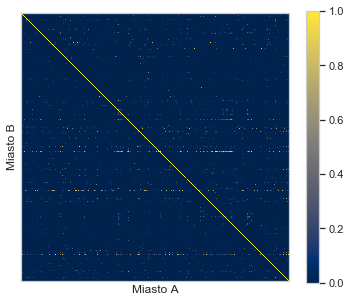

In [28]:
plt.rcParams['figure.figsize'] = [6, 5]
cm = confusion_matrix(city_users['city_x'], city_users['city_y'], sample_weight=city_users['count'])
cm = cm / cm.diagonal()
plt.imshow(cm, cmap='cividis')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel('Miasto A')
plt.ylabel('Miasto B')
plt.show()

In [13]:
business_df = business_df[business_df['city'] == 'Toronto']
b_num = business_df.shape[0]
b_num

10100

In [14]:
business_filter = business_df[['business_id']]

In [15]:
ratings_df = ratings_df.merge(business_filter, on='business_id')
r_num = ratings_df.shape[0]
r_num

800700

In [16]:
u_num = ratings_df['user_id'].unique().shape[0]
u_num

85811

In [17]:
r_num / (b_num * u_num)

0.0009238585696795548

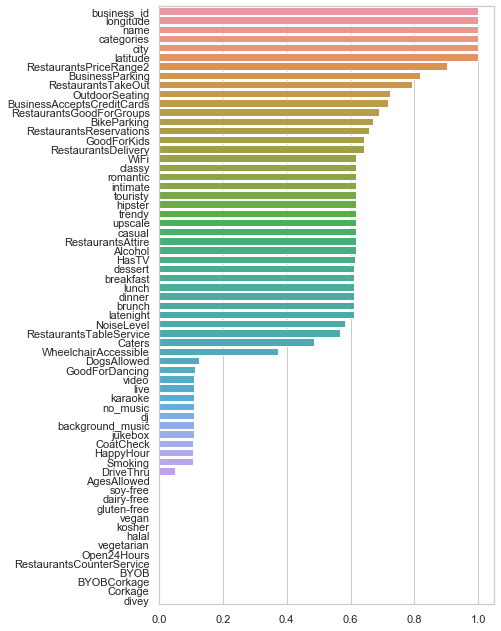

In [18]:
plt.rcParams['figure.figsize'] = [6, 11]
business_filled = (b_num - business_df.isnull().sum()) / b_num
business_filled.sort_values(ascending=False, inplace=True)
business_filled.index
# business_filled.index = pd.Index(['id', 'dł. geo.', 'nazwa', 'kategorie', 'miasto', 'szer. geo.',
#                                   'cena', 'parking', 'na wynos', 'ogródek', 'akceptuje karty',
#                                   'dobra dla grup', 'parking dla rowerów', 'wymagana rezerwacja', 'dobra dla dzieci',
#                                   'dostawa', 'WiFi', 'szykowna', 'romantyczna', 'intymna', 'dobra dla turystów',
#                                   'hipsterska', 'popularna', 'ekskluzywna', 'luźny klimat', 'dresscode', 'alkohol',
#                                   'tv', 'desery', 'śniadania', 'obiady', 'kolacje', 'brunche', 'otwarte nocą', 'hałas',
#                                   'obsługa', 'catering', 'rampa dla wózkówu', 'wstęp dla psów', 'taniec', 'radio',
#                                   'muzyka na żywo', 'karaoke', 'brak muzyki', 'dj', 'muzyka w tle', 'szafa grająca', 
#                                   'szatnia', 'happy hour', 'dozwolone palenie', 'drive-thru', 'wstęp dla nieletnich',
#                                   'dieta bez soi', 'dieta wolna od nabiału', 'dieta bezglutenowa', 'dieta wegańska',
#                                   'dieta koszerna', 'dieta halal', 'dieta wegetariańska', 'otwarte całą dobę',
#                                   'recepcja', 'BYOB', 'BYOB - obsługa', 'odkorkowywanie', 'obskórny kilmat'])
sns.barplot(x=business_filled, y=business_filled.index)
plt.xticks(rotation='horizontal')
plt.yticks(rotation='horizontal')
plt.show()

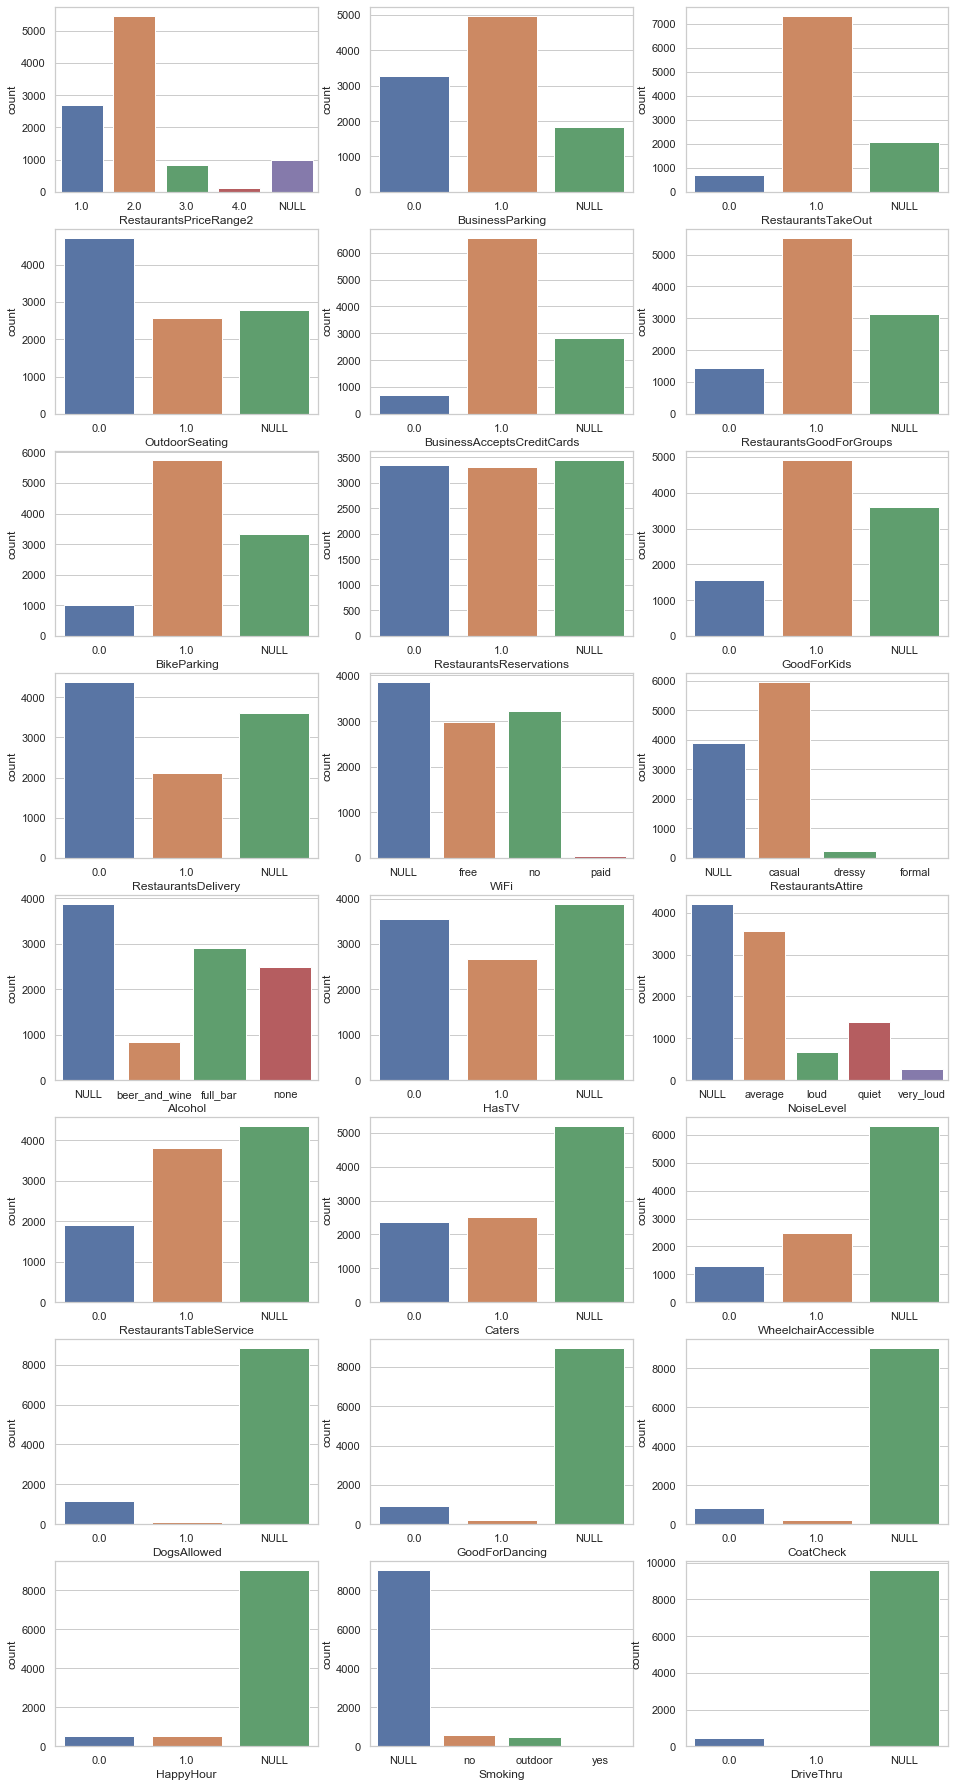

In [19]:
plt.rcParams['figure.figsize'] = [16, 32]

fig, ax = plt.subplots(8, 3)

business_attribs = ['RestaurantsPriceRange2', 'BusinessParking', 'RestaurantsTakeOut', 
                    'OutdoorSeating', 'BusinessAcceptsCreditCards', 'RestaurantsGoodForGroups',
                    'BikeParking', 'RestaurantsReservations', 'GoodForKids', 'RestaurantsDelivery',
                    'WiFi', 'RestaurantsAttire', 'Alcohol', 'HasTV', 'NoiseLevel', 'RestaurantsTableService', 
                    'Caters', 'WheelchairAccessible', 'DogsAllowed', 'GoodForDancing', 'CoatCheck', 
                    'HappyHour', 'Smoking', 'DriveThru']

business_tmp = business_df.fillna('NULL')

for idx, col in enumerate(business_attribs):
    sns.countplot(business_tmp[col].astype(str).sort_values(), ax=ax[idx // 3][idx % 3])

plt.show()

Text(0.5, 0, 'Ubiór')

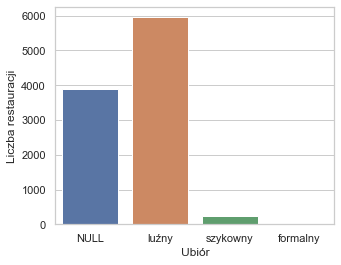

In [20]:
plt.rcParams['figure.figsize'] = [5, 4]
sns.countplot(business_tmp['RestaurantsAttire'].astype(str).sort_values().replace({'dressy': 'szykowny',
                                                                                   'formal': 'formalny',
                                                                                   'casual': 'luźny'}))
plt.ylabel('Liczba restauracji')
plt.xlabel('Ubiór')

In [21]:
categories = business_df
categories.categories = categories.categories.apply(lambda x: ast.literal_eval(x))
categories = pd.concat([categories['business_id'], categories['categories'].apply(pd.Series)], axis=1)
categories = categories.melt(id_vars='business_id').dropna()
categories = categories[['business_id', 'value']].rename({'value': 'category'}, axis=1)
categories = categories.groupby('category').count().sort_values('business_id', ascending=False)

categories left: 420, threshold: 0
categories left: 177, threshold: 0.001
categories left: 86, threshold: 0.005
categories left: 62, threshold: 0.01
categories left: 36, threshold: 0.02
categories left: 24, threshold: 0.03
categories left: 18, threshold: 0.04
categories left: 15, threshold: 0.05
categories left: 5, threshold: 0.1
categories left: 2, threshold: 0.2
categories left: 2, threshold: 0.3
categories left: 1, threshold: 0.4
categories left: 1, threshold: 0.5
categories left: 1, threshold: 0.6
categories left: 0, threshold: 0.8
categories left: 0, threshold: 1


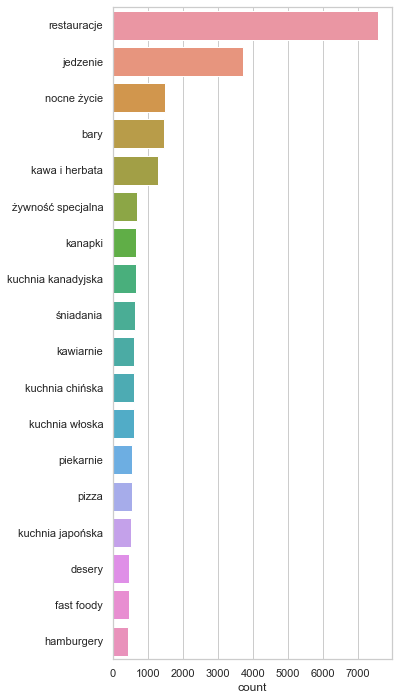

In [22]:
categories_tmp = categories

for threshold in (0, 0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1):
    categories_tmp = categories_tmp[categories_tmp['business_id'] >= (threshold * business_df.shape[0])]
    print(f'categories left: {categories_tmp.shape[0]}, threshold: {threshold}')

categories_tmp = categories
categories_tmp = categories_tmp[categories_tmp['business_id'] >= (0.04 * business_df.shape[0])]
categories_tmp = categories_tmp.rename({'business_id': 'count'}, axis=1)
categories_tmp.index = pd.Index(['restauracje', 'jedzenie', 'nocne życie', 'bary', 'kawa i herbata',
                                 'żywność specjalna', 'kanapki', 'kuchnia kanadyjska', 'śniadania',
                                 'kawiarnie', 'kuchnia chińska', 'kuchnia włoska', 'piekarnie', 'pizza',
                                 'kuchnia japońska', 'desery', 'fast foody', 'hamburgery'])

plt.rcParams['figure.figsize'] = [5, 12]
sns.barplot(x=categories_tmp['count'], y=categories_tmp.index)

In [23]:
business_df.head()

,business_id,name,categories,city,latitude,longitude,BikeParking,BusinessAcceptsCreditCards,BusinessParking,GoodForKids,...,live,video,jukebox,dairy-free,gluten-free,vegan,kosher,halal,soy-free,vegetarian
4,9A2quhZLyWk0akUetBd8hQ,Bnc Cake House,"[Food, Bakeries]",Toronto,43.664378,-79.414424,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,tZnSodhPwNr4bzrwJ1CSbw,Southern Accent Restaurant,"[Cajun/Creole, Southern, Restaurants]",Toronto,43.664125,-79.411886,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,5J3b7j3Fzo9ISjChmoUoUA,Mabel's Bakery,"[Food, Bakeries, Coffee & Tea]",Toronto,43.681328,-79.427884,1.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,PMDlKLd0Mxj0ngCpuUmE5Q,The Coffee Mill Restaurant,"[Restaurants, Food, Canadian (New), Coffee & Tea]",Toronto,43.670885,-79.392379,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,YIez_A3WOt9J2SXN7OMa2Q,Allwyn's Bakery,"[Caribbean, Food, Bakeries, Restaurants]",Toronto,43.745928,-79.324623,1.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Mapping

In [24]:
business_profile = business_df[['business_id','name']]

cats = ['Food', 'Nightlife', 'Bars', 'Coffee & Tea', 'Speciality Food', 'Sandwiches', 'Canadian (New)',
        'Breakfast & Brunch', 'Cafes', 'Chinese', 'Italian', 'Bakeries', 'Pizza', 'Japanese', 'Desserts',
        'Fast Food', 'Burgers']
for cat in cats:
    business_profile[cat] = business_df['categories'].apply(lambda x: 1 if cat in x else 0)
    
prices = {
    1: -1,
    2: 1,
    3: 2,
    4: 3,
    # np.nan: 0
}
business_profile['PriceRange'] = business_df['RestaurantsPriceRange2'].map(prices)
business_profile['PriceRange'].fillna(0, inplace=True)

bin_cats = {
    0: -1,
    1: 1,
    # np.nan: 0
}
for cat in ['BusinessAcceptsCreditCards', 'BusinessParking', 'OutdoorSeating', 'RestaurantsReservations',
            'RestaurantsTableService', 'Caters', 'casual', 'dinner', 'lunch']:
    business_profile[cat] = business_df[cat].map(bin_cats)
    business_profile[cat].fillna(0, inplace=True)
    
noise = {
    'quiet': -1,
    'average': 1,
    'loud': 2,
    'very_loud': 3,
    # np.nan: 0
}
business_profile['NoiseLevel'] = business_df['NoiseLevel'].map(noise)
business_profile['NoiseLevel'].fillna(0, inplace=True)

wifi = {
    'paid': 0,
    'free': 1,
    'no': -1,
    # np.nan: 0
}
business_profile['WiFi'] = business_df['WiFi'].map(wifi)
business_profile['WiFi'].fillna(0, inplace=True)

alcohol = {
    'full_bar': 1,
    'beer_and_wine': 1,
    'none': -1,
    # np.nan: 0
}
business_profile['Alcohol'] = business_df['Alcohol'].map(wifi)
business_profile['Alcohol'].fillna(0, inplace=True)

print(business_profile.columns)
business_profile.head(5)

Index(['business_id', 'name', 'Food', 'Nightlife', 'Bars', 'Coffee & Tea',
       'Speciality Food', 'Sandwiches', 'Canadian (New)', 'Breakfast & Brunch',
       'Cafes', 'Chinese', 'Italian', 'Bakeries', 'Pizza', 'Japanese',
       'Desserts', 'Fast Food', 'Burgers', 'PriceRange',
       'BusinessAcceptsCreditCards', 'BusinessParking', 'OutdoorSeating',
       'RestaurantsReservations', 'RestaurantsTableService', 'Caters',
       'casual', 'dinner', 'lunch', 'NoiseLevel', 'WiFi', 'Alcohol'],
      dtype='object')


,business_id,name,Food,Nightlife,Bars,Coffee & Tea,Speciality Food,Sandwiches,Canadian (New),Breakfast & Brunch,...,OutdoorSeating,RestaurantsReservations,RestaurantsTableService,Caters,casual,dinner,lunch,NoiseLevel,WiFi,Alcohol
4,9A2quhZLyWk0akUetBd8hQ,Bnc Cake House,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,tZnSodhPwNr4bzrwJ1CSbw,Southern Accent Restaurant,0,0,0,0,0,0,0,0,...,1.0,1.0,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,0.0
16,5J3b7j3Fzo9ISjChmoUoUA,Mabel's Bakery,1,0,0,1,0,0,0,0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
19,PMDlKLd0Mxj0ngCpuUmE5Q,The Coffee Mill Restaurant,1,0,0,1,0,0,1,0,...,1.0,-1.0,0.0,0.0,-1.0,-1.0,-1.0,1.0,0.0,0.0
37,YIez_A3WOt9J2SXN7OMa2Q,Allwyn's Bakery,1,0,0,0,0,0,0,0,...,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,0.0


In [25]:
business_reindexer = pd.DataFrame(data={'business_id': business_profile['business_id'],
                                        'iid': np.arange(business_profile.shape[0])})

user_reindexer = ratings_df.user_id.unique()
user_reindexer = pd.DataFrame(data={'user_id': user_reindexer, 'uid': np.arange(user_reindexer.shape[0])})

user_reindexer.head()

,user_id,uid
0,hxqo4NyJFfeOmuoVi--s1A,0
1,jdf15x7YE69Dd2a3o0hAag,1
2,M3q6GbQzbWpjZl87Gq2gpQ,2
3,hBb-5i6Jux-VtklhWorT5Q,3
4,cZ8E9v04bcG9dMWGZXSVuw,4


In [26]:
business_profile = business_reindexer.merge(business_profile, on='business_id', how='left')
business_profile = business_profile.drop('business_id', axis=1)
business_profile.to_csv(f'dataset/YELP/business_attributes.csv', index=False)

In [27]:
ratings_df = business_reindexer.merge(ratings_df, on='business_id', how='left')
ratings_df = user_reindexer.merge(ratings_df, on='user_id', how='left')
ratings_df = ratings_df.drop(['business_id', 'user_id'], axis=1)
ratings_df = ratings_df.rename({'stars': 'rating'}, axis=1)
ratings_df.to_csv(f'dataset/YELP/ratings.csv', index=False)